# RecDP LLM - fuzzy deduplication

Near Dedup is to Detect duplicated documents and output as a duplicates list.

* Step 1. We use DataSketch minHash as the base algorithm to calculate (hash, band_id) pair for each documents.

* Step 2. We use Spark and SlimPajama connected component detect documents who sharing the same (hash, band_id) pair.

* Step 3(Optional). We apply the duplication list to original file to elimate duplicated documents.


### use case:
* Expect Input format: a folder of *.jsonl.
* Expect Output format: a folder of *.jsonl after reduction.


# Get started

## Install pyrecdp and dependencies

In [ ]:
! DEBIAN_FRONTEND=noninteractive apt-get install -y openjdk-8-jre
! pip install pyrecdp --pre
# ! pip install 'git+https://github.com/intel/e2eAIOK.git#egg=pyrecdp&subdirectory=RecDP'

## 2. prepare your own data

In [2]:
%mkdir -p /content/test_data
%cd /content/test_data
file_names = ['NIH_sample.jsonl']
file_list = [f"https://raw.githubusercontent.com/intel/e2eAIOK/main/RecDP/tests/data/PILE/{i}" for i in file_names]
!wget -P /content/test_data {" ".join(file_list)}

/content/test_data
--2023-10-11 18:43:44--  https://raw.githubusercontent.com/intel/e2eAIOK/main/RecDP/tests/data/PILE/NIH_sample.jsonl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21626664 (21M) [text/plain]
Saving to: ‘/content/test_data/NIH_sample.jsonl’

NIH_sample.jsonl    100%[===================>]  20.62M   111MB/s    in 0.2s    

2023-10-11 18:43:45 (111 MB/s) - ‘/content/test_data/NIH_sample.jsonl’ saved [21626664/21626664]



## 3. fuzzy deduplicate (seperate detection and reduction)

In [3]:
! ls /content/test_data

NIH_sample.jsonl


### 3.1 PIPELINE based API

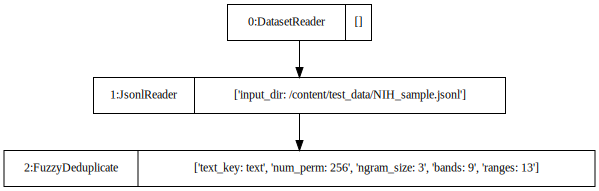

In [8]:
from pyrecdp.LLM import TextPipeline, ResumableTextPipeline
from pyrecdp.primitives.operations import *

pipeline = TextPipeline()
ops = [
    JsonlReader("/content/test_data/NIH_sample.jsonl"),
    FuzzyDeduplicate(text_key='text', num_perm = 256, ngram_size = 13, bands = 9, ranges = 13),
]
pipeline.add_operations(ops)
pipeline.plot()

In [9]:
ret = pipeline.execute()
ret.toPandas()

init spark
Will assign 1 cores and 10386 M memory for spark
per core memory size is 10.143 GB and shuffle_disk maximum capacity is 8589934592.000 GB
execute with spark started ...
num_bands is 9, ranges is 13
generate minHashLsh started ...
  generate minHashLsh took 81.08149501399998 sec
generate_connected_components => duplicates started ...


100%|██████████| 39/39 [00:00<00:00, 120810.82it/s]


  generate_connected_components => duplicates took 0.8133754819999695 sec
deduplicate input data started ...
  deduplicate input data took 1.318230944999982 sec
execute with spark took 83.63126261900004 sec


,text,meta
0,The National Domestic Violence Hotline (NDVH) ...,"{""APPLICATION_ID"":100065}"
1,"The Office of Planning, Research and Evaluatio...","{""APPLICATION_ID"":100066}"
2,Improving outcomes for low-income fathers and ...,"{""APPLICATION_ID"":100067}"
3,This project is implementing 36-month follow-u...,"{""APPLICATION_ID"":100068}"
4,The CCDF Policies Database is a source of info...,"{""APPLICATION_ID"":100069}"
...,...,...
9963,Project: Research and produce a videotape that...,"{""APPLICATION_ID"":2120612}"
9964,While relapse prevention has been studied and ...,"{""APPLICATION_ID"":2120613}"
9965,"The proposed study on recruitment, adherence a...","{""APPLICATION_ID"":2120616}"
9966,Recent studies suggest that HIV epidemics are ...,"{""APPLICATION_ID"":2120620}"
